In [1]:
from transformers import T5Tokenizer, T5Model, T5EncoderModel
import re
import torch


tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_uniref50', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

/scratch/users/anup/condaenv/envs/prot_model/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.22.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.13.layer.2.DenseReluDense.wi.weight', 'decoder.block.21.layer.2.DenseReluDense.wi.weight', 'decoder.block.16.layer.1.EncDecAttention.v.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.17.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'lm_head.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.2.layer.1.EncDecAttention.k.weight', 'decoder.block.20.layer.0.S

In [2]:


'''sequences_Example = ["A E T C Z A O", "S K T Z P C A"]
#sequences_Example = ["A E T C Z A O"]

sequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]

ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True)

input_ids = torch.tensor(ids['input_ids'])
attention_mask = torch.tensor(ids['attention_mask'])

features = []
agg_features = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

'''

'sequences_Example = ["A E T C Z A O", "S K T Z P C A"]\n#sequences_Example = ["A E T C Z A O"]\n\nsequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]\n\nids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True)\n\ninput_ids = torch.tensor(ids[\'input_ids\'])\nattention_mask = torch.tensor(ids[\'attention_mask\'])\n\nfeatures = []\nagg_features = []\nfor seq_num in range(len(embedding)):\n    seq_len = (attention_mask[seq_num] == 1).sum()\n    seq_emd = embedding[seq_num][:seq_len-1]\n    agg_features.append(np.mean(seq_emd, axis=0))\n    features.append(seq_emd)\n\n'

In [3]:
#from Bio import SeqIO
#fasta_sequences = SeqIO.parse("spike_protein.fasta", "fasta")

In [62]:
i_seq = 0
sequences = []
seq_df = pd.read_csv("data/genbank_spike_prot_clades.csv", sep=",")


for row in seq_df.iterrows():
    
    # name, seq = fasta.id.split(' ')[0], list(" ".join(str(fasta.seq)))
    #name, seq = fasta.id.split(" ")[0], str(fasta.seq)
    #print(name)
    # delete * signs prodigal puts at the end of sequence
    seq = row[1]["Sequence"]
    seq = re.sub("\*", "", seq)
    sequences.append(" ".join(seq))
    name = re.sub("\|", "_", name)
    name = re.sub("\/", "_", name)
    i_seq += 1
    if i_seq == 50:
        break

In [63]:
len(sequences)

50

In [ ]:
# map rarely occured amino acids (U,Z,O,B) to (X)
sequences = [re.sub(r"[UZOJB]", "X", sequence) for sequence in sequences]
# Tokenize, encode sequences and load it into the GPU if possibile
ids = tokenizer.batch_encode_plus(
    sequences, add_special_tokens=True, padding=True
)
input_ids = torch.tensor(ids["input_ids"])
attention_mask = torch.tensor(ids["attention_mask"])

with torch.no_grad():
    embedding = model(input_ids=input_ids, attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

In [45]:
import numpy as np
features = []
agg_features = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][: seq_len - 1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

In [46]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

X = np.array(agg_features) #np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]) #np.array(features) #np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X.shape

(10, 1024)

In [58]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X)
#X_embedded

In [59]:
z = X_embedded

In [60]:
df = pd.DataFrame()
#df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

df

,comp-1,comp-2
0,-21.681450,-33.480438
1,3.051962,-35.907860
2,-30.870512,-127.811798
3,-52.073215,-83.513054
4,-5.838793,-10.644740
5,-47.018772,-56.523861
6,-32.992943,-11.898447
7,-37.154076,-159.614822
8,-51.501530,-128.244232
9,-27.661240,-68.027069


<ipython-input-61-44551899b700>:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:10], palette=sns.color_palette("hls", 3), data=df).set(title="T-SNE projection")


[Text(0.5, 1.0, 'T-SNE projection')]

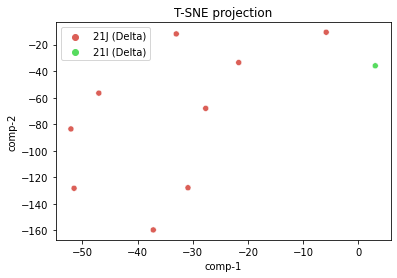

In [61]:
sns.scatterplot(x="comp-1", y="comp-2", hue=seq_df["Clade"].tolist()[:10], palette=sns.color_palette("hls", 3), data=df).set(title="T-SNE projection")